<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/hierarchy_ref.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

In [ ]:
#Pengunduhan dataset ke google colab
from google.colab import files
#ke proses 'upload'

In [ ]:
#penguploadan
uploaded = files.upload()

Saving vgchartz-2024.csv to vgchartz-2024.csv


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [ ]:
#Perpustakaan dasar
import numpy as np
import pandas as pd
#Grafik
import matplotlib.pyplot as plt
import seaborn as sns
#perpustakaan untuk interpolasi
from scipy.interpolate import interp1d
import random

In [ ]:
#Perpustakaan untuk inisiasi 'pelabelan' dan 'identifikasi jarak'
from sklearn.preprocessing import LabelEncoder as le
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
#Bagian K-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial import distance

In [ ]:
#Inisiasi scaler
from sklearn.preprocessing import StandardScaler #untuk PCA
from sklearn.preprocessing import RobustScaler #hierarki

In [ ]:
#lanjutan perpustakaan untuk dendodram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering as agcl #pengingat
import scipy.cluster.hierarchy as sch #hierarki
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans #Nilai Kmeans

In [ ]:
#optsional untuk hierarki 'kneed'
!pip install kneed
from kneed import KneeLocator

In [ ]:
#instalasi dill
! pip install dill
import dill

In [ ]:
#Lanjutan instalasi pool
import warnings #peringatan
import multiprocessing
from multiprocessing import Pool
import os #untuk os
import time

In [ ]:
#Silhouette visualizer
!pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
#Bagian 'datetime'
import datetime

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [ ]:
#Pengunduhan dataset
sdf = pd.read_csv('/content/vgchartz-2024.csv')
sdfc = sdf.copy()

In [ ]:
#Penyeleksian kolom penjualan
kolpen = ['total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales'] #indikator bagi penjualan
numerik = sdfc[kolpen].copy() #kolom numerik penjualan
#lihat contoh
cnth = numerik.head(7)
print("contoh data penjualan:")
print(cnth)

contoh data penjualan:
   total_sales  na_sales  jp_sales  pal_sales  other_sales
0        20.32      6.37      0.99       9.85         3.12
1        19.39      6.06      0.60       9.71         3.02
2        16.15      8.41      0.47       5.49         1.78
3        15.86      9.06      0.06       5.33         1.42
4        15.09      6.18      0.41       6.05         2.44
5        14.82      9.07      0.13       4.29         1.33
6        14.74      9.76      0.11       3.73         1.14


Bagian pertama dari kolom numerik

In [ ]:
#cek info data
catatan = sdfc.info()
print("informais data:")
print(catatan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   developer     63999 non-null  object 
 6   critic_score  6678 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  pal_sales     12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  56965 non-null  object 
 13  last_update   17879 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB
informais data:
None


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [ ]:
#Inisiasi EDA (memakai sdfcbsh)
top15jdl = sdfc.groupby('title')['total_sales'].sum().sort_values(ascending=False).head(15).copy() #Lihat urutan dahulu
#lihat hasil
top15jdl #lihat judul dl

,total_sales
title,
Grand Theft Auto V,64.29
Call of Duty: Black Ops,30.99
Call of Duty: Modern Warfare 3,30.71
Call of Duty: Black Ops II,29.59
Call of Duty: Ghosts,28.80
Call of Duty: Black Ops 3,26.72
Call of Duty: Modern Warfare 2,25.02
Minecraft,24.01
Grand Theft Auto IV,22.53


# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [ ]:
#cek data kosong
totkosong = sdf.isnull().sum()
print("total data kosong:")
print(totkosong)

total data kosong:
img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64


Hasil awal

In [ ]:
#pengisian kolom pengembang
kolpen = sdfc['developer'].copy() #salinan dari kolom pengembang/'developer'
kolpbt = sdfc['publisher'].copy() #salinan dari penerbit/'publisher'
pengkosong = np.where(kolpen.isnull(),True,False) #cek kolom pengembang kosong
#pengisian pengembang dari penerbit
kolpen = kolpen.fillna(kolpbt)
#cek proses pengisian
smpkpen = sdfc.head(7)
smpkpen

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14
5,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,X360,Shooter,Activision,Infinity Ward,8.7,14.82,9.07,0.13,4.29,1.33,2011-11-08,NaN
6,/games/boxart/full_call-of-duty-black-ops_5Ame...,Call of Duty: Black Ops,X360,Shooter,Activision,Treyarch,8.8,14.74,9.76,0.11,3.73,1.14,2010-11-09,NaN


Ini untuk pengisian kolom penerbit (ak harap benar)

In [ ]:
#Pengisian kolom penjualan dengan nilai median
nilmedpen = numerik.median()
#pengisian kolom kosong
kolpen = numerik.fillna(nilmedpen)
#cek proses pengisian
smpkpen = kolpen.head(7)
#lihat hasil
smpkpen

,total_sales,na_sales,jp_sales,pal_sales,other_sales
0,20.32,6.37,0.99,9.85,3.12
1,19.39,6.06,0.60,9.71,3.02
2,16.15,8.41,0.47,5.49,1.78
3,15.86,9.06,0.06,5.33,1.42
4,15.09,6.18,0.41,6.05,2.44
5,14.82,9.07,0.13,4.29,1.33
6,14.74,9.76,0.11,3.73,1.14


In [ ]:
#lihat hasil beda
bdjual = sdfc[np.where(abs(sdfc['total_sales'] - sdfc[['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].sum(axis=1)) > 0.1,True, False)].shape[0]
print("jumlah perbedaan :")
print(bdjual)

jumlah perbedaan :
0


In [ ]:
#cek kolom numerik pasca pengisian
totnonumer = kolpen.isna().sum()
print("total data kosong:")
print(totnonumer)

total data kosong:
total_sales    0
na_sales       0
jp_sales       0
pal_sales      0
other_sales    0
dtype: int64


setelah pengisian nilai median

### Pengurusan tanggal

In [ ]:
#Bagian awal (pembaruan)
rn_dnn = sdfc['release_date'].isnull() & sdfc['last_update'].notnull()
sdfc.loc[np.where(rn_dnn, True, False), 'release_date'] = sdfc.loc[np.where(rn_dnn, True, False),'release_date'].fillna(sdfc['last_update'])
#cek pengisian pertama
sdfc[np.where(rn_dnn, True, False)].head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
6347,/games/boxart/full_dangan-ronpa_0JapanFront.jpg,Danganronpa: Trigger Happy Havoc,PSP,Adventure,Unknown,Spike,NaN,0.24,NaN,0.24,NaN,NaN,2018-01-11,2018-01-11
14436,/games/boxart/full_8639439JapanFrontccc.jpg,PriPara All Idol Perfect Stage!,NS,Misc,Unknown,Takara Tomy ARTS,NaN,0.03,NaN,0.03,NaN,NaN,2018-04-04,2018-04-04
15449,/games/boxart/full_9121088AmericaFrontccc.jpg,Zumba Fitness: World Party,X360,Misc,Unknown,Zoe Mode,NaN,0.02,NaN,NaN,0.02,0.0,2018-04-01,2018-04-01
19006,/games/boxart/full_8394432AmericaFrontccc.jpg,How to Survive 2,PC,Action,Unknown,EKO Software,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-02,2019-02-02
19066,/games/boxart/full_6903656AmericaFrontccc.jpg,Geometry Dash,PC,Action,Unknown,RobTop Games,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-03,2019-02-03


In [ ]:
# Lanjutan untuk kondisi sebaliknya
rnn_dn = sdfc['release_date'].notnull() & sdfc['last_update'].isnull()
sdfc.loc[np.where(rnn_dn, True, False), 'last_update'] = sdfc.loc[np.where(rnn_dn, True, False),'last_update'].fillna(sdfc['release_date'])
#cek bagian kedia
sdfc[np.where(rnn_dn, True, False)].head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,2013-09-17
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,2002-10-28
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,2013-09-17
5,/games/boxart/full_call-of-duty-modern-warfare...,Call of Duty: Modern Warfare 3,X360,Shooter,Activision,Infinity Ward,8.7,14.82,9.07,0.13,4.29,1.33,2011-11-08,2011-11-08
6,/games/boxart/full_call-of-duty-black-ops_5Ame...,Call of Duty: Black Ops,X360,Shooter,Activision,Treyarch,8.8,14.74,9.76,0.11,3.73,1.14,2010-11-09,2010-11-09


In [ ]:
#Bagian untuk kedua kolom kosong
rn_dn = sdfc['release_date'].isnull() & sdfc['last_update'].isnull()
rctgl = sdfc[rn_dn].describe().round(3) #lihat hasil
rctgl #cek kolom kosong

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,25.000,87.000,17.000,36.000,47.000,56.000
mean,6.868,0.072,0.045,0.074,0.046,0.011
std,1.633,0.210,0.080,0.090,0.163,0.045
min,2.500,0.000,0.000,0.000,0.000,0.000
25%,6.000,0.000,0.000,0.018,0.000,0.000
50%,7.000,0.020,0.010,0.040,0.010,0.000
75%,8.000,0.060,0.020,0.103,0.025,0.000
max,9.000,1.840,0.250,0.420,1.100,0.330


In [ ]:
#isi kolom tanggal
sdfc['release_date'] = sdfc['release_date'].fillna(datetime.datetime(1900, 1, 1))
sdfc['last_update'] = sdfc['last_update'].fillna(datetime.datetime(1900, 1, 1))

In [ ]:
#isi nilai kritik
nilkrit = sdfc['critic_score'].copy()
mednil = nilkrit.median()
nilkrit = nilkrit.fillna(mednil)
#lihat kolom
sdfc['critic_score'] = nilkrit
nilkrit.describe()

,critic_score
count,64016.000000
mean,7.470837
std,0.478271
min,1.000000
25%,7.500000
50%,7.500000
75%,7.500000
max,10.000000


pengecekan kolom setelah **"pembersihan tanggal"**

In [ ]:
#lihat contoh kolom jadi
koltgl = pd.concat([sdfc['release_date'],sdfc['last_update']], axis=1)
#lihat info
inftgl = koltgl.info()
inftgl

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   release_date  64016 non-null  object
 1   last_update   64016 non-null  object
dtypes: object(2)
memory usage: 1000.4+ KB


Bagian kedua dari 'kolom bersih

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [ ]:
#Pemriksaan pasca pembersihan
totnumkol = pd.concat([kolpen, nilkrit], axis=1) #Basis untuk hierarki
infototkolnum = totnumkol.info()
print("informasi data:")
infototkolnum

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_sales   64016 non-null  float64
 1   na_sales      64016 non-null  float64
 2   jp_sales      64016 non-null  float64
 3   pal_sales     64016 non-null  float64
 4   other_sales   64016 non-null  float64
 5   critic_score  64016 non-null  float64
dtypes: float64(6)
memory usage: 2.9 MB
informasi data:


amlglamisasi kolom numerik

In [ ]:
#Inspeksi untuk seleksi kolom (penyatuan hasil data)
sisa = sdfc.iloc[:,:5].copy()
sisa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img        64016 non-null  object
 1   title      64016 non-null  object
 2   console    64016 non-null  object
 3   genre      64016 non-null  object
 4   publisher  64016 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB


sisa kolom bersih

In [ ]:
#Persiapan kolom bersih untuk pembuatan cluster
sdfcbsh = pd.concat([sisa,totnumkol, koltgl], axis=1, copy=True) #Ak harap benar
infodfbsh = sdfcbsh.info()
#lihat info
infodfbsh

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   total_sales   64016 non-null  float64
 6   na_sales      64016 non-null  float64
 7   jp_sales      64016 non-null  float64
 8   pal_sales     64016 non-null  float64
 9   other_sales   64016 non-null  float64
 10  critic_score  64016 non-null  float64
 11  release_date  64016 non-null  object 
 12  last_update   64016 non-null  object 
dtypes: float64(6), object(7)
memory usage: 6.3+ MB


Kolom untuk tabel

## Persiapan untuk pelabelan

In [ ]:
#deklarasi jenis konsol
jkonsol = sdfcbsh['console'].unique().copy() #salinan saja
print("jenis konsol:")
print(jkonsol)

jenis konsol:
['PS3' 'PS4' 'PS2' 'X360' 'XOne' 'PC' 'PSP' 'Wii' 'PS' 'DS' '2600' 'GBA'
 'NES' 'XB' 'PSN' 'GEN' 'PSV' 'DC' 'N64' 'SAT' 'SNES' 'GBC' 'GC' 'NS'
 '3DS' 'GB' 'WiiU' 'WS' 'VC' 'NG' 'WW' 'SCD' 'PCE' 'XBL' '3DO' 'GG' 'OSX'
 'Mob' 'PCFX' 'Series' 'All' 'iOS' '5200' 'And' 'DSiW' 'Lynx' 'Linux' 'MS'
 'ZXS' 'ACPC' 'Amig' '7800' 'DSi' 'AJ' 'WinP' 'iQue' 'GIZ' 'VB' 'Ouya'
 'NGage' 'AST' 'MSD' 'S32X' 'XS' 'PS5' 'Int' 'CV' 'Arc' 'C64' 'FDS' 'MSX'
 'OR' 'C128' 'CDi' 'CD32' 'BRW' 'FMT' 'ApII' 'Aco' 'BBCM' 'TG16']


ada **26** variasi konsol

In [ ]:
#deklarasi jenis game
jaksi = sdfcbsh['genre'].unique().copy() #salinan saja
print("jenis aksi:")
print(jaksi)

jenis aksi:
['Action' 'Shooter' 'Action-Adventure' 'Sports' 'Role-Playing'
 'Simulation' 'Racing' 'Music' 'Misc' 'Fighting' 'Platform' 'Adventure'
 'Strategy' 'Puzzle' 'MMO' 'Sandbox' 'Party' 'Education' 'Board Game'
 'Visual Novel']


maksudnya **Jenis permainan** di game

In [ ]:
#seleksi kolom untuk analisis hierarki
kolkon = sdfcbsh['console'].copy() #aplikasi untuk konsol
koljen = sdfcbsh['genre'].copy() #aplikasi untuk genre
#pengambilan numerik dr sdfcbsh
sdfbshnum = sdfcbsh.iloc[:,5:9].copy() #numerikal untuk kolom jadi

In [ ]:
#Konversi melalui pelabelan 'Multilabel Analyzer'
le_k = le() #konsol
le_j = le() #jenis game
#konversi ke matriks
matkon = le_k.fit_transform(kolkon) #konsol
matjen = le_j.fit_transform(koljen) #jenis game
#ke persiapan df

1. Basis lb di konsol adalah kemungkinan generasi konsol **"tua atau muda"**
2. Basis lb di jenis game adalah kemungkinan jenis **"menyenangkan atau menjenukan"**

In [ ]:
#persiapan df
dfkon = pd.DataFrame(data=matkon, columns=['kemungkinan generasi'])  # DF untuk konsol
dfjen = pd.DataFrame(data=matjen, columns=['kemungkinan menyenangkan'])  # DF untuk jenis
#ke hasil

In [ ]:
#lihat hasil
samp1 = dfkon.head(7)
samp2 = dfjen.head(7)
print("sampel konsol:")
print(samp1)
print("sampel jenis game:")
print(samp2)

sampel konsol:
   kemungkinan generasi
0                    54
1                    55
2                    53
3                    73
4                    55
5                    73
6                    73
sampel jenis game:
   kemungkinan menyenangkan
0                         0
1                         0
2                         0
3                         0
4                        15
5                        15
6                        15


In [ ]:
#penyatuan kolom vektor
hslvek = pd.concat([dfkon, dfjen], axis=1)
hslvek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   kemungkinan generasi      64016 non-null  int64
 1   kemungkinan menyenangkan  64016 non-null  int64
dtypes: int64(2)
memory usage: 1000.4 KB


Kolom pelabelan

## Persiapan untuk data numerik

In [ ]:
#pelabelan dengan 'robustscaler'
rscal = RobustScaler() #Robust
sscal = StandardScaler() #Standar
#pengubahan hasil ke bentuk distandarkan
robdfnum = rscal.fit_transform(sdfbshnum) # untuk hierarki
ssdfnum = sscal.fit_transform(sdfbshnum) #untuk PCA

In [ ]:
#Pengubahan ke bentuk df
dfrobnum = pd.DataFrame(data=robdfnum, columns=['na_sales', 'jp_sales', 'pal_sales', 'other_sales']) #untuk hierarki
dfssnum = pd.DataFrame(data=ssdfnum, columns=['na_sales', 'jp_sales', 'pal_sales', 'other_sales']) #untuk PCA
#lihat hasil di bawah

In [ ]:
#hasil
smpa = dfrobnum.head(7)
smpa

,na_sales,jp_sales,pal_sales,other_sales
0,20.20,6.25,0.95,9.81
1,19.27,5.94,0.56,9.67
2,16.03,8.29,0.43,5.45
3,15.74,8.94,0.02,5.29
4,14.97,6.06,0.37,6.01
5,14.70,8.95,0.09,4.25
6,14.62,9.64,0.07,3.69


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [ ]:
#Penyatuan dataset untuk analisis hierarki
dfkomb = pd.concat([dfrobnum, hslvek], sort=True, copy=True) #Dataset untuk hierarki
sampkomp = dfkomb.head(7)
sampkomp

,jp_sales,kemungkinan generasi,kemungkinan menyenangkan,na_sales,other_sales,pal_sales
0,6.25,NaN,NaN,20.20,9.81,0.95
1,5.94,NaN,NaN,19.27,9.67,0.56
2,8.29,NaN,NaN,16.03,5.45,0.43
3,8.94,NaN,NaN,15.74,5.29,0.02
4,6.06,NaN,NaN,14.97,6.01,0.37
5,8.95,NaN,NaN,14.70,4.25,0.09
6,9.64,NaN,NaN,14.62,3.69,0.07


jenis dataset **'dfkomb'** menjadi df untuk kluster

In [ ]:
#perispan nilai untuk hierarki
nilkomp = dfkomb.values.copy()

In [ ]:
#Deklarasi batas untuk perhitungan
minsil = 0.55 #nilai siluet minimal
optsil = 0.70 #nilai siluet optimal
#waktu maksimal
maxt = 43200 #deklarasi batas waktu eksekusi
#ke fungsi

In [ ]:
#Penulisan Fungsi
def dynamic_divisive_clustering(data, min_silhouette=minsil, optimal_silhouette=optsil, max_runtime=maxt):
    start_time = time.time()
    results = []
    #deklarasi kluster terkini
    current_clusters = [data]

    while current_clusters:
        elapsed_time = time.time() - start_time

        if elapsed_time > max_runtime:
            break

        cluster_to_split = current_clusters.pop(0)
        cluster_to_split = np.nan_to_num(cluster_to_split)

        #inspeksi bentuk
        if cluster_to_split.ndim == 1:
            cluster_to_split = cluster_to_split.reshape(1, -1)

        n_samples, n_features = cluster_to_split.shape
        if n_samples == 1:
            # Untuk sampel tunggal
            results.append((cluster_to_split, [0], 0)) # Jika label tunggal
            continue

        # Penekanan peringatan konvergensi
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)  # Abaikan
            kmeans = KMeans(n_clusters=2)
            labels = kmeans.fit_predict(cluster_to_split)

        n_labels = len(np.unique(labels))
        n_samples, n_features = cluster_to_split.shape

        #cek label
        if n_labels >= 2:
            silhouette_avg = silhouette_score(cluster_to_split, labels)
        else:
            silhouette_avg = 0

        # Pembulatan nilai siluet
        nil_siluet_bulat = round(silhouette_avg, 4)

        #cetak hasil
        print(f"Samples: {n_samples}, Features: {n_features}, Clusters: {n_labels}, Silhouette Score: {nil_siluet_bulat}")

        if nil_siluet_bulat >= min_silhouette:
            results.append((cluster_to_split, labels, nil_siluet_bulat))

            for i in range(2):
                current_clusters.append(cluster_to_split[labels == i])

            if nil_siluet_bulat >= optimal_silhouette:
                print(f"NIlai optimal : {nil_siluet_bulat}")
                break
            elif min_silhouette < nil_siluet_bulat < optimal_silhouette:
                print(f"Nilai Minimal dipenuhi dengan nilai : {nil_siluet_bulat}")
            else:
                print(f"Nilai tidak memenuhi karena nilai : {nil_siluet_bulat}")

    with open('clustering_results.dill', 'wb') as f:
        dill.dump(results, f)

    return results
#ke persiapan multiprocessing

In [ ]:
#persiapan multiprocessing
def parallel_dynamic_divisive_clustering(data_chunks):
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.map(dynamic_divisive_clustering, data_chunks)
    return results
#ke data

In [ ]:
#Persiapan data
datan = nilkomp.copy() #salinan saja (untuk uji asli)
data_chunks = np.array_split(datan, 6).copy() #salinan untuk dipotong

In [ ]:
#Eksekusi fungsi normal
hasilnpar = parallel_dynamic_divisive_clustering(datan) #paralelisasi normal menjadi 6 segmen atau analisis utuh
#paralelisasi data
hslkombinasi = [] #kombinasi hasil paralel
for result in hasilnpar:
    hslkombinasi.extend(result) #gabungan

In [ ]:
#penyimpanan hasil
with open('combined_clustering_results.dill', 'wb') as f:
    dill.dump(hasilnpar, f)

In [ ]:
#cek kondisional untuk Penyimpana hasil 'dill' di normal (fasa penyimpanan)
if os.path.exists('combined_clustering_results.dill'):
    with open('combined_clustering_results.dill', 'rb') as f:
        loaded_results = dill.load(f)

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [ ]:
#Modifikasi dengan 'seleksi fitur'
def sf_dynamic_clustering(data, feature_indices=None, min_silhouette=0.55, optimal_silhouette=0.70, max_runtime=43200):
    start_time = time.time()
    results = []
    current_clusters = [data]

    # Use feature indices if provided
    if feature_indices is not None:
        # Check if data is a list of chunks
        if isinstance(data, list):
            # Inspeksi potongan data melalui seleksi fitur
            data = [np.nan_to_num(np.array(chunk)[:, feature_indices], nan=0.0) for chunk in data]
        else:
            # Penerapan langsung
            data = data[:, feature_indices]
    #kondisional untuk instansi
    if isinstance(data, list):
        current_clusters = data
    else:  #Deklarasi
        current_clusters = [data]

    while current_clusters:
        elapsed_time = time.time() - start_time

        if elapsed_time > max_runtime:
            break

        cluster_to_split = current_clusters.pop(0)
        cluster_to_split = np.nan_to_num(cluster_to_split)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            kmeans = KMeans(n_clusters=2)
            labels = kmeans.fit_predict(cluster_to_split)

        n_labels = len(np.unique(labels))

        if n_labels >= 2:
            silhouette_avg = silhouette_score(cluster_to_split, labels)
        else:
            silhouette_avg = 0

        nil_siluet_bulat = round(silhouette_avg, 4)

        if nil_siluet_bulat >= min_silhouette:
            results.append((cluster_to_split, labels, nil_siluet_bulat))

            for i in range(2):
                current_clusters.append(cluster_to_split[labels == i])

            if nil_siluet_bulat >= optimal_silhouette:
                print(f"NIlai optimal : {nil_siluet_bulat}")
                break
            elif (nil_siluet_bulat >= min_silhouette) and (nil_siluet_bulat < optimal_silhouette):
                print(f"Nilai Minimal dipenuhi dengan nilai : {nil_siluet_bulat}")
            else:
                print(f"Nilai tidak memenuhi karena nilai : {nil_siluet_bulat}")

    with open('clustering_results.dill', 'wb') as f:
        dill.dump(results, f)

    return results
    #ke perhitungan multiprocessing

In [ ]:
#seksi perhitungan 'weightened average'
def calculate_weighted_average(results):
    total_weighted_score = 0
    total_samples = 0

    for cluster_data in results:
        cluster, _, silhouette_score = cluster_data
        n_samples = len(cluster)

        total_weighted_score += silhouette_score * n_samples
        total_samples += n_samples

    if total_samples == 0:  # Avoid division by zero
        return 0

    weighted_average = total_weighted_score / total_samples
    return weighted_average
  #persiapan multiprocessing

In [ ]:
#persiapan multiprocessing
def dynamic_divisive_clustering(data, feature_indices, min_silhouette, optimal_silhouette):
    # Persiapan hasil pembagian divisiv
    return data, [], 0.55  # mock output

def parallel_dynamic_divisive_clustering(data_chunks, feature_indices=None, min_silhouette=0.55, optimal_silhouette=0.70):
    with multiprocessing.Pool() as pool:
        results = pool.starmap(dynamic_divisive_clustering,
                               [(chunk, feature_indices, min_silhouette, optimal_silhouette) for chunk in data_chunks])

    #flattened_results = [item for sublist in results for item in sublist]
    weighted_average_score = calculate_weighted_average(results)

    print(f"Weighted Average Silhouette Score: {weighted_average_score:.4f}")

    return results
#ke data

In [ ]:
#Persiapan data
datan = nilkomp.copy()  # salinan saja
data_chunks = np.array_split(datan, 6).copy()  # salinan untuk dipoting

# Pemilihan fitur (di kolom 1 dan 2)
selected_features = [1, 2]  # cek kemungkinan

In [ ]:
#Eksekusi basian 1
results = sf_dynamic_clustering(datan, feature_indices=selected_features)
#ke perhitungan 'weightened average'

NIlai optimal : 0.791


In [ ]:
#perhitungan nilai 'weightened average'
weighted_average_score = calculate_weighted_average(results)

In [ ]:
#eksekusi dengan 'seleksi fitur' dengan fitur yang dipilih
hasilnparsf = parallel_dynamic_divisive_clustering(data_chunks, feature_indices=selected_features)  # paralelisasi normal menjadi 6 segmen
# Paralelisasi data
hslkombinasisf = []  # kombinasi hasil paralel
for result in hasilnparsf:
    hslkombinasi.extend(result)  # gabungan

#ke penyimpanan hasil sf

TypeError: parallel_dynamic_divisive_clustering() got an unexpected keyword argument 'feature_indices'

In [ ]:
# Penyimpanan hasil
with open('sf_combined_clustering_results.dill', 'wb') as f:
    dill.dump(hslkombinasi, f)
#ke penyimpanan kluster

In [ ]:
#Pengetahuan jumlah kluster untuk Cek kondisional pada Penyimpanan hasil 'dill' di normal (fasa penyimpanan)
if os.path.exists('sf_combined_clustering_results.dill'):
    with open('sf_combined_clustering_results.dill', 'rb') as f:
        loaded_results = dill.load(f)

## **d. Visualisasi Hasil Clustering**

In [ ]:
# Visualisasi normal
if loaded_results:
    if isinstance(loaded_results, list) and loaded_results:
        last_cluster_data = loaded_results[-1]

        # Further check if the last element is a list and has at least one element before accessing the first one
        if isinstance(last_cluster_data, list) and last_cluster_data:
            last_cluster_data = last_cluster_data[0]
        else:
            print("The last element of loaded_results or its first element is not a list. Check data format.")
            last_cluster_data = None  # Set to None to skip visualization
    else:
        print("loaded_results is not a list or is empty. Check data loading.")
        last_cluster_data = None  # Set to None to skip visualization

    if isinstance(last_cluster_data, np.ndarray) and last_cluster_data.ndim == 2:
        # If it's a well-formed 2D array, proceed directly
        pass
    elif isinstance(last_cluster_data, (list, tuple)):  # Handle both lists and tuples
        # Check if it's a list of lists/tuples and they have varying lengths
        if all(isinstance(sublist, (list, tuple)) for sublist in last_cluster_data):
            max_len = max(len(sublist) for sublist in last_cluster_data)
            # Pad each sublist to ensure uniform length
            last_cluster_data = [
                list(sublist) + [0] * (max_len - len(sublist))
                for sublist in last_cluster_data
            ]
            # Convert to NumPy array after padding
            last_cluster_data = np.array(last_cluster_data)
        else:
            print(f"Unexpected structure in last_cluster_data: {last_cluster_data}")
            print(f"Jenis kluster : {type(last_cluster_data)}")
            try:
                print(f"Bentuk terakhir : {np.shape(last_cluster_data)}")
            except ValueError:
                print("last_cluster_data has an inconsistent shape.")
            print("Skipping PCA visualization due to inconsistent data shape.")
            last_cluster_data = None  # Set to None to skip PCA

    if last_cluster_data is not None:  # Proceed only if data is valid
        pca = PCA(n_components=0.95)
        X_pca = pca.fit_transform(last_cluster_data)

        plt.figure(figsize=(10, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], s=30)
        plt.title('Hasil PCA di kluster terakhit')
        plt.xlabel('Konsep Prinsipal 1')
        plt.ylabel('Konsep Prinsipal 2')  # Corrected ylabel
        plt.grid()
        plt.show()

The last element of loaded_results or its first element is not a list. Check data format.


Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [ ]:
#Inspeksi PCA di seleksi fitur
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
principal_components = pca.fit_transform(ssdfnum)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

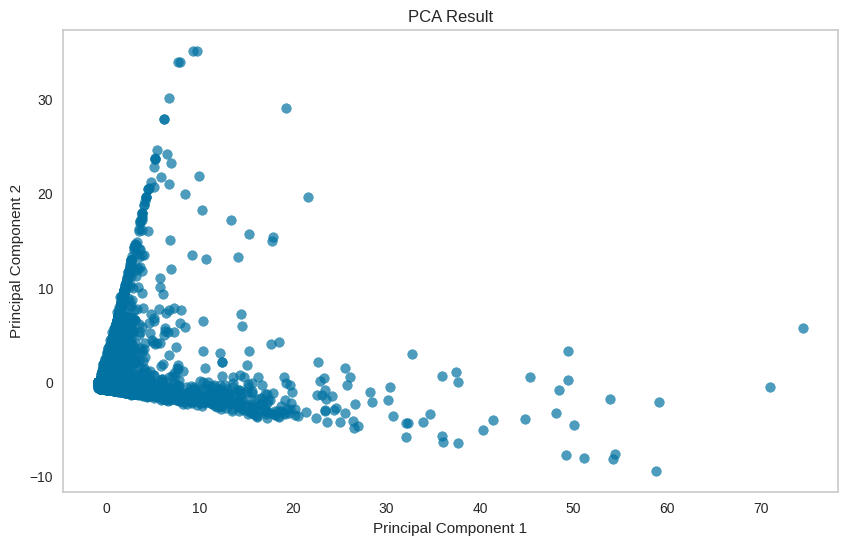

In [ ]:
#Visualisasi fasa fitur
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [ ]:
#cek dendogram (hasil kluster normal adalah 'hasilnpar')
all_labels = []
for result in hasilnpar:
    for cluster, labels, _ in result:
        all_labels.append(labels)
#perataan label
lbldtr = np.concatenate(all_labels) #kondisi normal

In [ ]:
#Deklarasi sampel (normal)
uksampel = 100  # Penyetelan
if len(nilkomp) > uksampel:
    sampled_indices = random.sample(range(len(nilkomp)), uksampel)
    sampled_data = nilkomp[sampled_indices]
else:
    sampled_data = nilkomp

In [ ]:
#matriks untuk dendrigam (kondisi normal)
nilkomp_finite = np.nan_to_num(nilkomp)
Znor = linkage(nilkomp_finite, method='average', metric= 'cityblock', optimal_ordering=True)
#ke ilustrasi

In [ ]:
#Ilustrasi dalam kondisi normal
plt.figure(figsize=(10, 7))
dendrogram(Znor, leaf_rotation=90., leaf_font_size=12.)
plt.title('Dendrogram from Divisive Clustering')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

In [ ]:
#Cek dendrogram untuk seleksi fitur


## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
#Bagian awal


In [ ]:
#Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.